In [13]:
import argparse
import json
import os
import pickle as pkl
import sys
import time
import warnings
from typing import List, Optional
from collections import defaultdict
import pathlib
import shutil

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents.methods import candidate

sys.path.append("../")

import awkward as ak
import vector

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
! ls ../rootfiles

GluGluHToWWToLNuQQ_M.root      TTbar
GluGluHToWW_Pt-200ToInf_M.root WJets
HWW                            outfiles
QCD


In [3]:
! ls vjetsnlo/

WJetsToLNu_012JetsNLO_34JetsLO_EWNLOcorr.root
outfiles
outfiles_noselection
outfiles_noselectionnotrigger
outfiles_preselection
rootfiles


In [267]:
! ls vjetsnlo/outfiles/0-1_ele.parquet

0-1.pkl         0-1_ele.parquet 0-1_mu.parquet


In [315]:
df_ele = pd.read_parquet("vjetsnlo/outfiles/0-1_ele.parquet")
df_mu = pd.read_parquet("vjetsnlo/outfiles/0-1_mu.parquet")

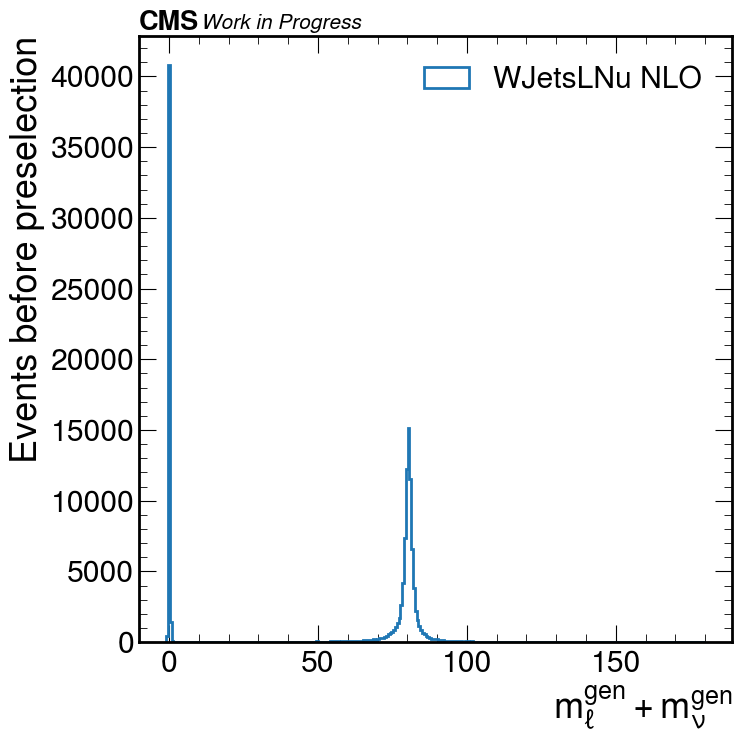

In [319]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(
    df["gen_V_mass"],
    bins=np.linspace(-1,180,300),
    histtype="step",
    lw=2,
    label="WJetsLNu NLO",
#     density=True,
)
ax.legend()
ax.set_xlabel(r"$m^{gen}_{\ell} + m^{gen}_{\nu}$")
ax.set_ylabel("Events before preselection")

hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.tight_layout()
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/NLO_genV.pdf")

In [4]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

In [7]:
# load a hww root file into coffea-friendly NanoAOD structure

# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/WJets/file1.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events_LO = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events_LO

number of events per file is 65000
number of events per file is 184325


<NanoEventsArray [<event 1:36226:327908759>, ... ] type='184325 * event'>

In [11]:
import awkward as ak
import numpy as np
import vector

def get_lep(events):
    msk_genstatus = events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"]) & (events.GenPart.status==1)
    msk_genlep = (
        (abs(events.GenPart.pdgId) == ELE_PDGID) |
        (abs(events.GenPart.pdgId) == MU_PDGID) |
        (abs(events.GenPart.pdgId) == TAU_PDGID)
    )

    return events.GenPart[msk_genstatus & msk_genlep]

def get_neutrino(events):
    msk_genstatus = events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"]) & (events.GenPart.status==1)
    msk_gennu = (
        (abs(events.GenPart.pdgId) == vELE_PDGID) |
        (abs(events.GenPart.pdgId) == vMU_PDGID) |
        (abs(events.GenPart.pdgId) == vTAU_PDGID)
    )

    return events.GenPart[msk_genstatus & msk_gennu]

def get_p4(ptkl):
    return vector.awk(
        ak.zip(
            {
                "pt": ak.where(ak.num(ptkl.pt) == 0, [[0.0]], ptkl.pt),
                "eta": ak.where(ak.num(ptkl.eta) == 0, [[0.0]], ptkl.eta),
                "phi": ak.where(ak.num(ptkl.phi) == 0, [[0.0]], ptkl.phi),
                "e": ak.where(ak.num(ptkl.energy) == 0, [[0.0]], ptkl.energy),
            }
        )
    )

import uproot
f = uproot.open(f"vjetsnlo/WJetsToLNu_012JetsNLO_34JetsLO_EWNLOcorr.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events_NLO = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events_NLO

lep_p4 = get_p4(get_lep(events_NLO))
nu_p4 = get_p4(get_neutrino(events_NLO))

mW = ak.firsts((lep_p4 + nu_p4).mass).to_numpy()

number of events per file is 65000


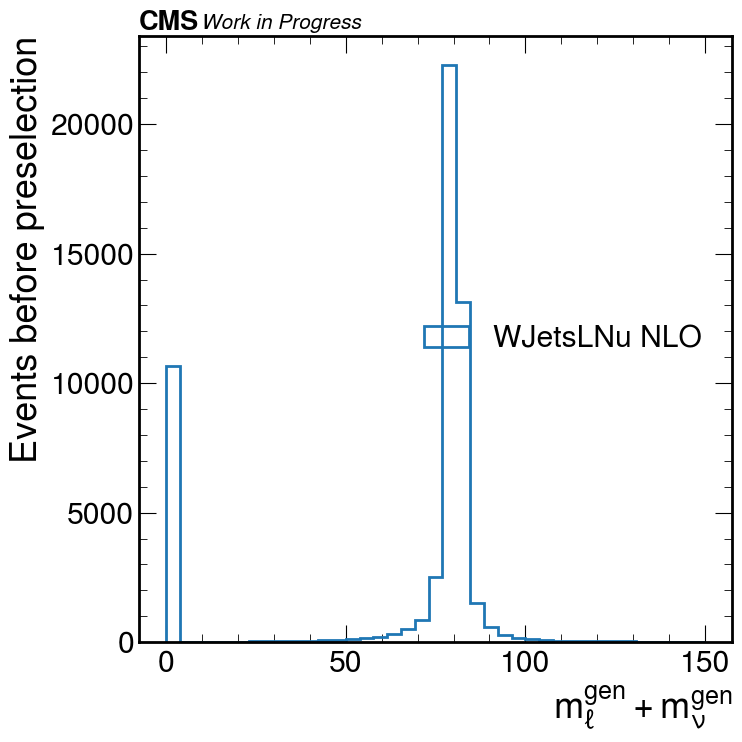

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(
    mW,
    bins=np.linspace(0,150,40),
    histtype="step",
    lw=2,
    label="WJetsLNu NLO",
#     density=True,
)
ax.legend()
ax.set_xlabel(r"$m^{gen}_{\ell} + m^{gen}_{\nu}$")
ax.set_ylabel("Events before preselection")

hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/NLO_genV.pdf")

In [155]:
nu_p4[1]

<MomentumArray4D [... phi: 2.64, eta: -0.639, t: 28.7}] type='1 * Momentum4D["rh...'>

In [126]:
lep_p4[get_lep(events_LO).pt!=0]

<MomentumArray4D [[], [{rho: 55.4, ... t: 205}]] type='184325 * var * Momentum4D...'>

<Array [[], [True], [], ... True], [], [True]] type='184325 * var * bool'>

In [96]:
msk_genstatus = events_NLO.GenPart.hasFlags(["fromHardProcess", "isLastCopy"]) & (events_NLO.GenPart.status==1)
msk_genlep = (
    (abs(events_NLO.GenPart.pdgId) == ELE_PDGID) |
    (abs(events_NLO.GenPart.pdgId) == MU_PDGID) |
    (abs(events_NLO.GenPart.pdgId) == TAU_PDGID)
)

gp = events_NLO.GenPart[msk_genstatus & msk_genlep]
# gp = events_NLO.GenPart[msk_genlep]

abs(gp.pdgId)

<Array [[], [11], [], [13, ... [13], [], [11]] type='184325 * var * int32'>

In [97]:
# events w/o lep
nolep = ak.sum(ak.num(abs(gp.pdgId)) == 0)
ele = ak.sum(abs(gp.pdgId)==ELE_PDGID)
mu = ak.sum(abs(gp.pdgId)==MU_PDGID)

print(f"events with no lep: {nolep}")
print(f"events with ele: {ele}")
print(f"events with mu: {mu}")

events with no lep: 62000
events with ele: 61426
events with mu: 60899


In [ ]:
ak.fill_none(gp.pdgId

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

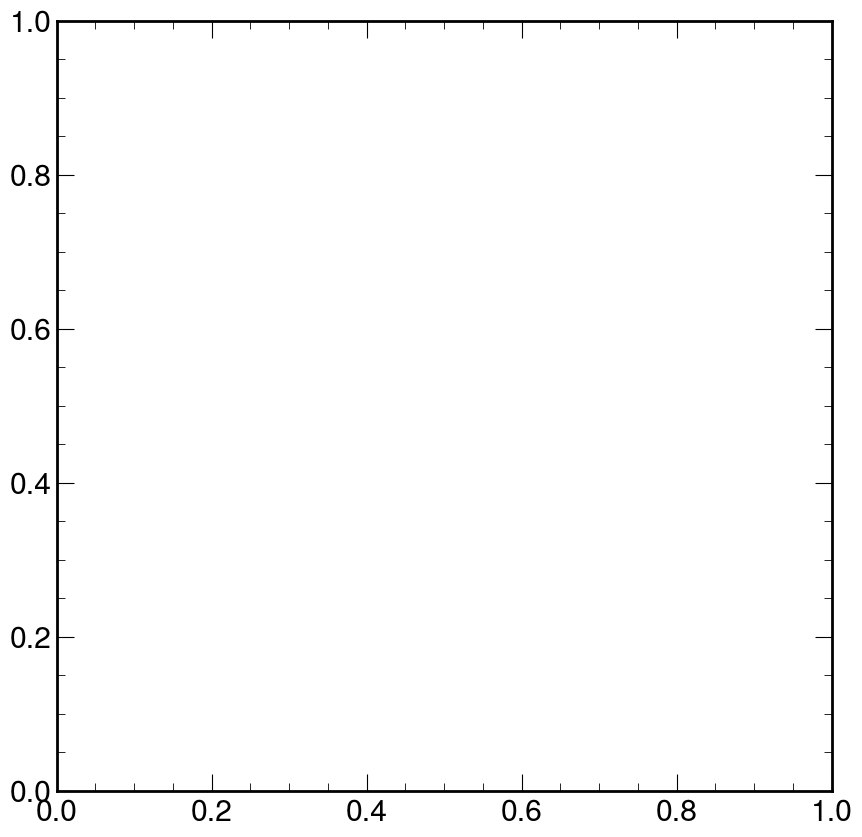

In [80]:
plt.hist(
    abs(gp.pdgId),
);

In [55]:
msk = events_NLO.GenPart.hasFlags(["fromHardProcess", "isLastCopy"]) & (events_NLO.GenPart.status==1)

events_NLO.GenPart.[msk & (abs(events_NLO.GenPart["pdgId"])==ELE_PDGID)]

<Array [[19.3], [], [], ... [], [], [229]] type='65000 * var * float32[parameter...'>

In [56]:
abs(gp["pdgId"])==ELE_PDGID

<Array [[True, False], ... [True, False]] type='65000 * var * bool'>

In [31]:
events_NLO.GenPart.status

<Array [[11, 11, 11, 11, 3, ... 1, 1, 1, 1, 1]] type='65000 * var * int32[parame...'>

In [3]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events

number of events per file is 15000


<NanoEventsArray [<event 1:100:99001>, ... ] type='15000 * event'>

In [28]:
def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]


genparts = events.GenPart
HIGGS_PDGID = 25

higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

In [29]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

# lepton
electrons = events["Electron"][events["Electron"].pt > 40]
muons = events["Muon"][events["Muon"].pt > 30]
leptons = ak.concatenate([electrons, muons], axis=1)
leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
candidatelep = ak.firsts(leptons)
candidatelep_p4 = build_p4(candidatelep)

# fatjet
fatjets = events["FatJet"]
good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

good_fatjets = fatjets[good_fatjets]  # select good fatjets
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

# candidatefj
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

# genVars = match_H(events.GenPart, candidatefj)

In [124]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


genparts = events.GenPart
fatjet = candidatefj
dau_pdgid=W_PDGID
signature="ggF"
fatjet_pt=None

    
higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

# pick higgs closest to jet (no requirement of matching yet)
matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)]
# make a mask
matched_higgs_mask = ak.any(fatjet.delta_r(matched_higgs) < 0.8, axis=1)

# get the higgs closest to jet
matched_higgs = ak.firsts(matched_higgs)
matched_higgs_children = matched_higgs.children
higgs_children = higgs.children

genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

if dau_pdgid == W_PDGID:
    children_mask = get_pid_mask(matched_higgs_children, [W_PDGID], byall=False)

    children_all_mask = get_pid_mask(ak.firsts(higgs).children, [W_PDGID], byall=False)
    is_decay = ak.any(children_all_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    matched_higgs_children = matched_higgs_children[children_mask]
    children_mass = matched_higgs_children.mass
    v_star = ak.firsts(matched_higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(matched_higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    print(higgs)
    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs[:, 0]),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus = ak.flatten(all_daus, axis=2)
    all_daus_flat = ak.flatten(all_daus, axis=2)
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # # prongs except neutrino
    # neutrinos = (
    #     (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    # )
    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat_pdgId <= b_PDGID]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_bquarks = ak.sum(
        fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR,
        axis=1,
    )

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass

    gen_lepton = ak.firsts(lep_daughters)

    # identifying the leptonic gen V
    Ws_children_pdgid = abs(matched_higgs_children.children.pdgId)
    msk_isVlep = (Ws_children_pdgid == ELE_PDGID) | (Ws_children_pdgid == MU_PDGID) | (Ws_children_pdgid == TAU_PDGID)
    msk_isVhad = ~msk_isVlep

    genVlep = ak.firsts(matched_higgs_children[ak.singletons(ak.argmax(ak.sum(msk_isVlep, axis=-1), axis=-1))])
    genVhad = ak.firsts(matched_higgs_children[ak.singletons(ak.argmax(ak.sum(msk_isVhad, axis=-1), axis=-1))])

    genHVVVars = {
        "num_quarks": num_quarks,
        "num_m_quarks": num_m_quarks,
        "fj_nbquarks": num_m_bquarks,
        "fj_lepinprongs": num_m_leptons,
        "fj_H_VV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_H_VV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_H_VV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_H_VV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_H_VV_lep": to_label((num_quarks == 0)),
        "fj_H_VV_isVlepton": iswlepton,
        "fj_H_VV_isVstarlepton": iswstarlepton,
        "fj_H_VV": is_decay,
        "fj_H_VV_isMatched": matched_higgs_mask,
        "gen_Vlep_pt": gen_lepton.pt,
        "genlep_dR_fj": fatjet.delta_r(gen_lepton),
        "fj_genRes_mass": matched_higgs.mass,
        # added on Oct 2, 2024
        "fj_genRes_pt": matched_higgs.pt,
        "genVhad_pt": genVhad.pt,
        "genVlep_pt": genVlep.pt,
        "dR_genVhad_genlep": genVhad.delta_r(gen_lepton),
        "dR_genVlep_genlep": genVlep.delta_r(gen_lepton),
    }

    genVars = {**genVars, **genVVars, **genHVVVars}

[[GenParticle], [GenParticle], [GenParticle, ... [GenParticle], [GenParticle]]


/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/coffea/nanoevents/methods/nanoaod.py:107: UserWarning: distinctChildrenDeep may not give correct answers for all generators!
  warnings.warn(


In [128]:
events.Tau.fields

['chargedIso',
 'dxy',
 'dz',
 'eta',
 'leadTkDeltaEta',
 'leadTkDeltaPhi',
 'leadTkPtOverTauPt',
 'mass',
 'neutralIso',
 'phi',
 'photonsOutsideSignalCone',
 'pt',
 'puCorr',
 'rawDeepTau2017v2p1VSe',
 'rawDeepTau2017v2p1VSjet',
 'rawDeepTau2017v2p1VSmu',
 'rawIso',
 'rawIsodR03',
 'charge',
 'decayMode',
 'jetIdx',
 'idAntiEleDeadECal',
 'idAntiMu',
 'idDecayModeOldDMs',
 'idDeepTau2017v2p1VSe',
 'idDeepTau2017v2p1VSjet',
 'idDeepTau2017v2p1VSmu',
 'cleanmask',
 'genPartIdx',
 'genPartFlav',
 'genPartIdxG',
 'jetIdxG']

In [172]:
ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

events.Tau["decayMode"]

<Array [[], [0, 5, 1], [0, ... [], [], [], []] type='15000 * var * int32[paramet...'>

In [173]:
leptonic_taus = (events.Tau["decayMode"] == ELE_PDGID) | (events.Tau["decayMode"] == MU_PDGID)
leptonic_taus

<Array [[], [False, False, ... [], []] type='15000 * var * bool'>

In [179]:
ak.sum(ak.any(leptonic_taus, axis=1))

777

In [178]:
msk = ~ak.any(leptonic_taus, axis=1)
msk

<Array [True, True, True, ... True, True, True] type='15000 * bool'>

777

In [43]:
matched_higgs_children

<GenParticleArray [GenParticle, GenParticle] type='2 * ?genParticle'>

In [72]:
pdgid_

<Array [[[1, 2], [11, 12, ... 15, 16], [1, 2]]] type='15000 * option[var * optio...'>

In [64]:
msk_isVlep[0]

<Array [[False, False], [True, False]] type='2 * option[var * ?bool]'>

In [117]:
sel_

<Array [[1], [], [], [], ... [], [], [], [0]] type='15000 * var * int64'>

In [123]:
    Ws_children_pdgid = abs(matched_higgs_children.children.pdgId)
    msk_isVlep = (Ws_children_pdgid == ELE_PDGID) | (Ws_children_pdgid == MU_PDGID) | (Ws_children_pdgid == TAU_PDGID)

    msk_isVlep = ~msk_isVlep
    sel_ = ak.singletons(ak.argmax(ak.sum(msk_isVlep, axis=-1), axis=-1))
    ak.firsts(matched_higgs_children[sel_]).children.pdgId
    
    

<Array [[-1, 2], None, None, ... None, [1, -2]] type='15000 * option[var * ?int3...'>

In [101]:
matched_higgs_children[0]

<GenParticleArray [GenParticle, GenParticle] type='2 * ?genParticle'>

<GenParticleArray [GenParticle, None, ... GenParticle] type='15000 * ?genParticle'>

In [21]:
genparts = events.GenPart

In [52]:
tops = genparts[get_pid_mask(genparts, TOP_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

# take all possible daughters!
daughters = ak.flatten(tops.distinctChildren, axis=2)
daughters = daughters[daughters.hasFlags(GEN_FLAGS)]
daughters_pdgId = abs(daughters.pdgId)

wboson_daughters = ak.flatten(daughters[(daughters_pdgId == W_PDGID)].distinctChildren, axis=2)
wboson_daughters = wboson_daughters[wboson_daughters.hasFlags(["fromHardProcess", "isLastCopy"])]
wboson_daughters_pdgId = abs(wboson_daughters.pdgId)

neutrinos = (
    (wboson_daughters_pdgId == vELE_PDGID)
    | (wboson_daughters_pdgId == vMU_PDGID)
    | (wboson_daughters_pdgId == vTAU_PDGID)
)

leptons = (
    (wboson_daughters_pdgId == ELE_PDGID)
    | (wboson_daughters_pdgId == MU_PDGID)
    | (wboson_daughters_pdgId == TAU_PDGID)
)

quarks = wboson_daughters_pdgId < b_PDGID

lepVars = {
    "lepton_pt": wboson_daughters[leptons].pt,
    "lepton_eta": wboson_daughters[leptons].eta,
    "lepton_phi": wboson_daughters[leptons].phi,
    "lepton_mass": wboson_daughters[leptons].mass,
}

quarkVars = {
    "quark_pt": wboson_daughters[quarks].pt,
    "quark_eta": wboson_daughters[quarks].eta,
    "quark_phi": wboson_daughters[quarks].phi,
    "quark_mass": wboson_daughters[quarks].mass,
}


In [53]:
wboson_daughters[quarks]

<GenParticleArray [[GenParticle, ... GenParticle]] type='46000 * var * ?genParticle'>

In [50]:
wboson_daughters[quarks][ak.num(wboson_daughters[quarks])==2].pdgId

<Array [[1, -2], [4, -3], ... [1, -2], [4, -3]] type='45564 * var * ?int32[param...'>

In [61]:
msk = ~ak.is_none(candidatefj)

num_m_quarks_nob = ak.sum(candidatefj[msk].delta_r(wboson_daughters[quarks][msk]) < JET_DR, axis=1)
num_m_quarks_nob

<Array [0, 0, 2, 0, 0, 2, ... 1, 2, 0, 0, 2, 0] type='4836 * ?int64'>

In [69]:
np.unique(num_m_quarks_nob.to_numpy().data, return_counts=True)

(array([0, 1, 2]), array([2756, 1310,  770]))

In [40]:
ak.sum(ak.num(quarkVars["quark_eta"])!=2)

436

In [38]:
ak.num(quarkVars["quark_eta"])

<Array [3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3] type='46000 * int64'>

In [318]:
genVars

{'fj_genH_pt': <Array [283, 249, 240, 273, ... 270, 244, 347] type='15000 * float64'>,
 'fj_genH_jet': <Array [3.33, None, None, ... None, None, 2.71] type='15000 * ?float32'>,
 'fj_genV_dR': <Array [3.35, None, None, ... None, None, 2.69] type='15000 * ?float32'>,
 'fj_genVstar': <Array [3.32, None, None, ... None, None, 2.73] type='15000 * ?float32'>,
 'genV_genVstar_dR': <Array [0.205, 0.668, 0.106, ... 1.13, 0.0656] type='15000 * ?float32'>,
 'fj_isHVV': <Array [True, True, True, ... True, True, True] type='15000 * ?bool'>,
 'fj_isHVV_Matched': <Array [False, None, None, ... None, False] type='15000 * ?bool'>,
 'fj_isHVV_4q': <Array [0, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 1, 0] type='15000 * ?int32'>,
 'fj_isHVV_elenuqq': <Array [1, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 0] type='15000 * ?int32'>,
 'fj_isHVV_munuqq': <Array [0, 0, 0, 1, 0, 0, ... 0, 0, 1, 0, 0, 0] type='15000 * ?int32'>,
 'fj_isHVV_taunuqq': <Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1] type='15000 * ?int32'>,
 'fj_isHVV_V

In [307]:
msk = genVars["fj_isHVV_Matched"]
msk

<Array [False, None, None, ... None, False] type='15000 * ?bool'>

In [326]:
a = genVars["fj_nquarks"][msk]
a[~ak.is_none(a)]

<Array [1, 3, 4, 2, 1, 2, ... 2, 1, 1, 1, 1, 1] type='2773 * ?int64'>

In [17]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/TTbar/file1.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()
events

number of events per file is 46000


<NanoEventsArray [<event 1:5575:5574008>, ... ] type='46000 * event'>

In [327]:
a = candidatefj.eta[msk]
a[~ak.is_none(a)][0]

0.0496063232421875

In [328]:
a = genVars["quark_eta"][msk]
a[~ak.is_none(a)][0]

<Array [-0.476, 0.223] type='2 * ?float32[parameters={"__doc__": "eta"}]'>

In [ ]:
candidatefj.delta_r()

In [329]:
higgs = ak.firsts(genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)])
print(higgs.type)

15000 * ?genParticle


In [330]:
matched_higgs_mask = fatjet.delta_r(higgs) < 0.8
print(matched_higgs_mask.type)

15000 * ?bool


In [331]:
matched_higgs = higgs[matched_higgs_mask]
matched_higgs.type

12036 * ?genParticle

In [332]:
children_mask = get_pid_mask(higgs.children, [W_PDGID], byall=False)
is_hww = ak.any(children_mask, axis=1)

# order by mass, select lower mass child as V* and higher as V
higgs_children = higgs_children[children_mask]
children_mass = higgs_children.mass
v_star = ak.firsts(higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
v = ak.firsts(higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

print(is_hww.type)
print(v.type)

15000 * ?bool
15000 * ?genParticle


In [333]:
# VV daughters
# requires coffea-0.7.21
all_daus = higgs_children.distinctChildrenDeep
all_daus_flat = ak.flatten(all_daus, axis=2)  # flattents the daighters of the two Ws
all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

In [334]:
print(all_daus.type)

15000 * option[var * option[var * ?genParticle]]


In [335]:
print(all_daus_flat.type)

15000 * option[var * ?genParticle]


In [336]:
higgs_children[0].pdgId

<Array [24, -24] type='2 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [350]:
abs(all_daus_flat[4].pdgId)

<Array [3, 4, 1, 2] type='4 * ?int32'>

In [349]:
num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
num_quarks[4]

4

In [355]:
a = num_quarks[matched_higgs_mask]
a[~ak.is_none(a)]

<Array [2, 4, 4, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='2773 * ?int64'>

In [377]:
a = all_daus_flat[~neutrinos & ~leptons][matched_higgs_mask]
a[~ak.is_none(a)].eta

<Array [[-0.476, 0.223], ... [0.102, -0.855]] type='2773 * option[var * ?float32...'>

In [381]:
a = fatjet[matched_higgs_mask]
a[~ak.is_none(a)].eta

<Array [0.0496, -1.16, ... 0.00714, -0.809] type='2773 * ?float32[parameters={"_...'>

In [382]:
a = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)[matched_higgs_mask]
a[~ak.is_none(a)]

<Array [1, 3, 4, 2, 1, 2, ... 2, 1, 1, 1, 1, 1] type='2773 * ?int64'>

In [403]:
ak.num(genVars["quark_eta"])

<Array [2, 2, 4, 2, 4, 2, ... 4, 4, 2, 4, 4, 2] type='15000 * ?int64'>

In [391]:
a = fatjet[matched_higgs_mask]
fj = a[~ak.is_none(a)]

a = all_daus_flat[~neutrinos & ~leptons][matched_higgs_mask]
quarks = a[~ak.is_none(a)]

a = (fj.delta_r(quarks) < JET_DR)
a[~ak.is_none(a)]

<Array [[False, True], ... [False, True]] type='2773 * option[var * ?bool]'>

In [393]:
fj.eta

<Array [0.0496, -1.16, ... 0.00714, -0.809] type='2773 * ?float32[parameters={"_...'>

In [394]:
quarks.eta

<Array [[-0.476, 0.223], ... [0.102, -0.855]] type='2773 * option[var * ?float32...'>

In [407]:
a = num_m_quarks[matched_higgs_mask]
np.unique(a[~ak.is_none(a)], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 290,  819, 1063,  395,  178,   27,    1]))

In [267]:
# the following tells you about the decay
num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
num_leptons = ak.sum(
    (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
    axis=1,
)
num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)


In [401]:
        # the following tells you about the matching
        # prongs except neutrino
        neutrinos = (
            (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
        )
        leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

        # num_m: number of matched leptons
        # number of quarks excludes neutrino and leptons
        num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
        num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
        num_m_cquarks = ak.sum(
            fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR,
            axis=1,
        )


In [266]:
        lep_daughters = all_daus_flat[leptons]
        # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
        parent = ak.firsts(lep_daughters.distinctParent)
        iswlepton = parent.mass == v.mass
        iswstarlepton = parent.mass == v_star.mass

        gen_lepton = ak.firsts(lep_daughters)


In [396]:
fatjet

<FatJetArray [FatJet, None, None, ... None, FatJet] type='15000 * ?fatJet'>

In [398]:
higgs

<GenParticleArray [GenParticle, ... GenParticle] type='15000 * ?genParticle'>

<Array [0, None, None, None, ... None, None, 0] type='15000 * ?int64'>

In [2]:
d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


btagWPs = {
    "deepJet": {
        "2016APV": {
            "L": 0.0508,
            "M": 0.2598,
            "T": 0.6502,
        },
        "2016": {
            "L": 0.0480,
            "M": 0.2489,
            "T": 0.6377,
        },
        "2017": {
            "L": 0.0532,
            "M": 0.3040,
            "T": 0.7476,
        },
        "2018": {
            "L": 0.0490,
            "M": 0.2783,
            "T": 0.7100,
        },
    },
    "deepCSV": {
        "2016APV": {
            "L": 0.2027,
            "M": 0.6001,
            "T": 0.8819,
        },
        "2016": {
            "L": 0.1918,
            "M": 0.5847,
            "T": 0.8767,
        },
        "2017": {
            "L": 0.1355,
            "M": 0.4506,
            "T": 0.7738,
        },
        "2018": {
            "L": 0.1208,
            "M": 0.4168,
            "T": 0.7665,
        },
    },
}

In [3]:
year = "2018"

In [4]:

        # ak4 jets
        ak4_jet_selector_no_btag = (
            (events.Jet.pt > 30) & (abs(events.Jet.eta) < 5.0) & events.Jet.isTight & (events.Jet.puId > 0)
        )


        goodjets = events.Jet[ak4_jet_selector_no_btag]
        ht = ak.sum(goodjets.pt, axis=1)

        dr_jet_lepfj = goodjets.delta_r(candidatefj)
        ak4_outside_ak8 = goodjets[dr_jet_lepfj > 0.8]
        NumOtherJets = ak.num(ak4_outside_ak8)

        # VBF variables
        jet1 = ak4_outside_ak8[:, 0:1]
        jet2 = ak4_outside_ak8[:, 1:2]
        deta = abs(ak.firsts(jet1).eta - ak.firsts(jet2).eta)
        mjj = (ak.firsts(jet1) + ak.firsts(jet2)).mass
        jj_pt = (ak.firsts(jet1) + ak.firsts(jet2)).pt

        # rec_higgs
        candidateNeutrino = ak.zip(
            {
                "pt": met.pt,
                "eta": candidatelep_p4.eta,
                "phi": met.phi,
                "mass": 0,
                "charge": 0,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        rec_W_lnu = candidatelep_p4 + candidateNeutrino
        rec_W_qq = candidatefj - candidatelep_p4
        rec_higgs = rec_W_qq + rec_W_lnu

        # INPUT VARIABLES
        # CANDIDATE JET
        fj_vars = [
                "eta",
                "phi",
                "mass",
                "pt",
                "msoftdrop",
                "lsf3",
            ]
        

        FatJetVars = {f"fj_{var}": ak.fill_none(candidatefj[var], FILL_NONE_VALUE) for var in fj_vars}

        # CANDIDATE LEPTON
        LepVars = {}
        LepVars["lep_dR_fj"] = candidatelep_p4.delta_r(candidatefj).to_numpy().filled(fill_value=0)
        LepVars["lep_pt"] = (candidatelep_p4.pt).to_numpy().filled(fill_value=0)
        LepVars["lep_pt_ratio"] = (candidatelep_p4.pt / candidatefj.pt).to_numpy().filled(fill_value=0)
        LepVars["lep_reliso"] = lep_reliso.to_numpy().filled(fill_value=0)
        LepVars["lep_miso"] = lep_miso.to_numpy().filled(fill_value=0)

        # MET
        METVars = {}
        METVars["met_pt"] = met.pt
        METVars["met_relpt"] = met.pt / candidatefj.pt
        METVars["met_fj_dphi"] = met.delta_phi(candidatefj)
        METVars["abs_met_fj_dphi"] = np.abs(met.delta_phi(candidatefj))
        METVars["mt_lep_met"] = mt_lep_met.to_numpy().filled(fill_value=0)

        # OTHERS

        # bjet
        Others = {}
        Others["n_bjets_L"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["L"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )
        Others["n_bjets_M"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["M"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )
        Others["n_bjets_T"] = (
            ak.sum(ak4_outside_ak8.btagDeepFlavB > btagWPs["deepJet"][year]["T"], axis=1)
            .to_numpy()
            .filled(fill_value=0)
        )

        # RECONSTRUCTED MASS
        Others["rec_W_lnu_pt"] = rec_W_lnu.pt.to_numpy().filled(fill_value=0)
        Others["rec_W_lnu_m"] = rec_W_lnu.mass.to_numpy().filled(fill_value=0)
        Others["rec_W_qq_pt"] = rec_W_qq.pt.to_numpy().filled(fill_value=0)
        Others["rec_W_qq_m"] = rec_W_qq.mass.to_numpy().filled(fill_value=0)
        Others["rec_higgs_pt"] = rec_higgs.pt.to_numpy().filled(fill_value=0)
        Others["rec_higgs_m"] = rec_higgs.mass.to_numpy().filled(fill_value=0)

        # ggF & VBF
        Others["mjj"] = mjj.to_numpy().filled(fill_value=0)
        Others["jj_pt"] = jj_pt.to_numpy().filled(fill_value=0)
        Others["deta"] = deta.to_numpy().filled(fill_value=0)
        Others["j1_pt"] = ak.firsts(jet1).pt.to_numpy().filled(fill_value=0)
        Others["j2_pt"] = ak.firsts(jet2).pt.to_numpy().filled(fill_value=0)
        Others["j1_m"] = ak.firsts(jet1).mass.to_numpy().filled(fill_value=0)
        Others["j2_m"] = ak.firsts(jet2).mass.to_numpy().filled(fill_value=0)


        # ggF & VBF
#         Others["ht"] = ht.to_numpy().filled(fill_value=0)
#         Others["NumFatjets"] = NumFatjets.to_numpy().filled(fill_value=0)
#         Others["NumOtherJets"] = NumOtherJets.to_numpy().filled(fill_value=0)
        Others["FirstFatjet_pt"] = FirstFatjet.pt.to_numpy().filled(fill_value=0)
        Others["FirstFatjet_m"] = FirstFatjet.mass.to_numpy().filled(fill_value=0)
        Others["SecondFatjet_pt"] = SecondFatjet.pt.to_numpy().filled(fill_value=0)
        Others["SecondFatjet_m"] = SecondFatjet.mass.to_numpy().filled(fill_value=0)

NameError: name 'events' is not defined

In [ ]:
skimmed_vars = {**FatJetVars, **METVars, **LepVars, **Others}

In [ ]:
def add_selection(
    name: str, sel: np.ndarray, selection: PackedSelection, cutflow: dict, isData: bool, signGenWeights: ak.Array
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    cutflow[name] = (
        np.sum(selection.all(*selection.names))
        if isData
        # add up sign of genWeights for MC
        else np.sum(signGenWeights[selection.all(*selection.names)])
    )


def add_selection_no_cutflow(name: str, sel: np.ndarray, selection: PackedSelection):
    """adds selection to PackedSelection object"""
    selection.add(name, ak.fill_none(sel, False))


In [ ]:
# apply selections
selection = PackedSelection()
add_selection_no_cutflow("fjselection", (candidatefj.pt > 250), selection)


In [ ]:
candidatefj.lsf3

In [ ]:

for (key, value) in skimmed_vars.items():
    print(key)
    skimmed_vars = {
                key: np.squeeze(np.array(value[selection.all(*selection.names)]))
            }

In [ ]:
 mjj.to_numpy().filled(fill_value=0)

In [ ]:
mjj.to_numpy().filled(fill_value=0)

In [ ]:
 ak.firsts(jet1).pt.to_numpy().filled(fill_value=0)

In [ ]:
ht

In [ ]:
ak.firsts(jet1.pt)

In [ ]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

def get_pid_mask(
    genparts: GenParticleArray,
    pdgids: Union[int, list],
    ax: int = 2,
    byall: bool = True,
) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) == list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask

In [6]:
! ls 

Feb7_build_tagger_inputs.ipynb         gen_matching_deep.ipynb
Feb7_matching_functions.ipynb          ggF_exploration.ipynb
Jul21_btag.ipynb                       ggh.root
Jul21_btagSF.ipynb                     hists_plots-tagger.ipynb
Jul21_rhalphalib.ipynb                 hists_plots.ipynb
July6_VBF_exploration.ipynb            hists_plots.ipynb.invalid
July6_hists_plots_zll.ipynb            hists_plots_sculpting.ipynb
July6_regressed_mass.ipynb             lol
July6_s_over_b.ipynb                   merged_file.root
July6_weights.ipynb                    mini-isolation.ipynb
June29_gen_matching.ipynb              neg_weights
README.md                              ntuples
bulkgraviton.root                      old
check_signal_tth.ipynb                 outfiles
coffea_playground.ipynb                processors.zip
combine.ipynb                          rhalphalib_hww.ipynb
combine_sig.ipynb                      roc_curves.ipynb
create_datacard.py                     run_blinded.sh
cut

In [8]:
from typing import Dict, Tuple, Union

import awkward as ak
import numpy as np
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

d_PDGID = 1
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

GAMMA_PDGID = 22
Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

PI_PDGID = 211
PO_PDGID = 221
PP_PDGID = 111

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

JET_DR = 0.8


def get_pid_mask(genparts: GenParticleArray, pdgids: Union[int, list], ax: int = 2, byall: bool = True) -> ak.Array:
    """
    Get selection mask for gen particles matching any of the pdgIds in ``pdgids``.
    If ``byall``, checks all particles along axis ``ax`` match.
    """
    gen_pdgids = abs(genparts.pdgId)

    if type(pdgids) is list:
        mask = gen_pdgids == pdgids[0]
        for pdgid in pdgids[1:]:
            mask = mask | (gen_pdgids == pdgid)
    else:
        mask = gen_pdgids == pdgids

    return ak.all(mask, axis=ax) if byall else mask


def to_label(array: ak.Array) -> ak.Array:
    return ak.values_astype(array, np.int32)


def match_H(genparts: GenParticleArray, fatjet: FatJetArray):
    """Gen matching for Higgs samples"""
    higgs = genparts[get_pid_mask(genparts, HIGGS_PDGID, byall=False) * genparts.hasFlags(GEN_FLAGS)]

    # only select events that match an specific decay
    # matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)][:, 0]
    matched_higgs = higgs[ak.argmin(fatjet.delta_r(higgs), axis=1, keepdims=True)]
    matched_higgs_mask = ak.any(fatjet.delta_r(matched_higgs) < 0.8, axis=1)

    matched_higgs = ak.firsts(matched_higgs)

    matched_higgs_children = matched_higgs.children
    higgs_children = higgs.children

    children_mask = get_pid_mask(matched_higgs_children, [W_PDGID], byall=False)
    is_hww = ak.any(children_mask, axis=1)

    # order by mass, select lower mass child as V* and higher as V
    matched_higgs_children = matched_higgs_children[children_mask]
    children_mass = matched_higgs_children.mass
    v_star = ak.firsts(matched_higgs_children[ak.argmin(children_mass, axis=1, keepdims=True)])
    v = ak.firsts(matched_higgs_children[ak.argmax(children_mass, axis=1, keepdims=True)])

    # VV daughters
    # requires coffea-0.7.21
    all_daus = higgs_children.distinctChildrenDeep
    all_daus = ak.flatten(all_daus, axis=2)
    all_daus_flat = ak.flatten(all_daus, axis=2)
    all_daus_flat_pdgId = abs(all_daus_flat.pdgId)

    # the following tells you about the decay
    num_quarks = ak.sum(all_daus_flat_pdgId <= b_PDGID, axis=1)
    num_leptons = ak.sum(
        (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID),
        axis=1,
    )
    num_electrons = ak.sum(all_daus_flat_pdgId == ELE_PDGID, axis=1)
    num_muons = ak.sum(all_daus_flat_pdgId == MU_PDGID, axis=1)
    num_taus = ak.sum(all_daus_flat_pdgId == TAU_PDGID, axis=1)

    # the following tells you about the matching
    # prongs except neutrino
    neutrinos = (
        (all_daus_flat_pdgId == vELE_PDGID) | (all_daus_flat_pdgId == vMU_PDGID) | (all_daus_flat_pdgId == vTAU_PDGID)
    )
    leptons = (all_daus_flat_pdgId == ELE_PDGID) | (all_daus_flat_pdgId == MU_PDGID) | (all_daus_flat_pdgId == TAU_PDGID)

    # num_m: number of matched leptons
    # number of quarks excludes neutrino and leptons
    num_m_quarks = ak.sum(fatjet.delta_r(all_daus_flat[~neutrinos & ~leptons]) < JET_DR, axis=1)
    num_m_leptons = ak.sum(fatjet.delta_r(all_daus_flat[leptons]) < JET_DR, axis=1)
    num_m_cquarks = ak.sum(fatjet.delta_r(all_daus_flat[all_daus_flat.pdgId == b_PDGID]) < JET_DR, axis=1)

    lep_daughters = all_daus_flat[leptons]
    # parent = ak.firsts(lep_daughters[fatjet.delta_r(lep_daughters) < JET_DR].distinctParent)
    parent = ak.firsts(lep_daughters.distinctParent)
    iswlepton = parent.mass == v.mass
    iswstarlepton = parent.mass == v_star.mass

    genVars = {"fj_genH_pt": ak.fill_none(higgs.pt, FILL_NONE_VALUE)}

    genVVars = {
        "fj_genH_jet": fatjet.delta_r(higgs[:, 0]),
        "fj_genV_dR": fatjet.delta_r(v),
        "fj_genVstar": fatjet.delta_r(v_star),
        "genV_genVstar_dR": v.delta_r(v_star),
    }

    genHVVVars = {
        "fj_isHVV": is_hww,
        "fj_isHVV_Matched": matched_higgs_mask,
        "fj_isHVV_4q": to_label((num_quarks == 4) & (num_leptons == 0)),
        "fj_isHVV_elenuqq": to_label((num_electrons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_munuqq": to_label((num_muons == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_taunuqq": to_label((num_taus == 1) & (num_quarks == 2) & (num_leptons == 1)),
        "fj_isHVV_Vlepton": iswlepton,
        "fj_isHVV_Vstarlepton": iswstarlepton,
        "fj_genRes_mass": matched_higgs.mass,
        "fj_nquarks": num_m_quarks,
        "fj_ncquarks": num_m_cquarks,
        "fj_lepinprongs": num_m_leptons,
    }

    genVars = {**genVars, **genVVars, **genHVVVars}

    return genVars, is_hww


In [22]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")

f = uproot.open(f"bulkgraviton.root")

num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 1000


In [23]:
        def build_p4(cand):
            return ak.zip(
                {
                    "pt": cand.pt,
                    "eta": cand.eta,
                    "phi": cand.phi,
                    "mass": cand.mass,
                    "charge": cand.charge,
                },
                with_name="PtEtaPhiMCandidate",
                behavior=candidate.behavior,
            )

        met = events.MET

        # lepton
        electrons = events["Electron"][events["Electron"].pt > 40]
        muons = events["Muon"][events["Muon"].pt > 30]
        leptons = ak.concatenate([electrons, muons], axis=1)
        leptons = leptons[ak.argsort(leptons.pt, ascending=False)]
        candidatelep = ak.firsts(leptons)
        candidatelep_p4 = build_p4(candidatelep)

        # fatjet
        fatjets = events["FatJet"]
        good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight

        good_fatjets = fatjets[good_fatjets]  # select good fatjets
        good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

        NumFatjets = ak.num(good_fatjets)
        FirstFatjet = ak.firsts(good_fatjets[:, 0:1])
        SecondFatjet = ak.firsts(good_fatjets[:, 1:2])

        # candidatefj
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj = ak.firsts(good_fatjets[fj_idx_lep])


In [21]:
match_H(events.GenPart, candidatefj)

({'fj_genH_pt': <Array [[283], [249], ... [244], [347]] type='15000 * var * float32[parameters={...'>,
  'fj_genH_jet': <Array [3.33, None, None, ... None, None, 2.71] type='15000 * ?float32'>,
  'fj_genV_dR': <Array [3.35, None, None, ... None, None, 2.69] type='15000 * ?float32'>,
  'fj_genVstar': <Array [3.32, None, None, ... None, None, 2.73] type='15000 * ?float32'>,
  'genV_genVstar_dR': <Array [0.205, None, None, ... None, 0.0656] type='15000 * ?float32'>,
  'fj_isHVV': <Array [True, None, None, ... None, None, True] type='15000 * ?bool'>,
  'fj_isHVV_Matched': <Array [False, None, None, ... None, False] type='15000 * ?bool'>,
  'fj_isHVV_4q': <Array [0, 0, 1, 0, 1, 0, ... 1, 1, 0, 1, 1, 0] type='15000 * int32'>,
  'fj_isHVV_elenuqq': <Array [1, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 0] type='15000 * int32'>,
  'fj_isHVV_munuqq': <Array [0, 0, 0, 1, 0, 0, ... 0, 0, 1, 0, 0, 0] type='15000 * int32'>,
  'fj_isHVV_taunuqq': <Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1] type='15000 * i

In [24]:
match_H(events.GenPart, candidatefj)

({'fj_genH_pt': <Array [[2.45e+03, 2.33e+03, ... 1.82e+03]] type='1000 * var * float32[parameter...'>,
  'fj_genH_jet': <Array [0.00877, 0.0215, ... 1.49, 0.00846] type='1000 * ?float32'>,
  'fj_genV_dR': <Array [0.0749, 0.0672, ... 1.47, 0.0268] type='1000 * ?float32'>,
  'fj_genVstar': <Array [0.0721, 0.0303, ... 1.52, 0.0102] type='1000 * ?float32'>,
  'genV_genVstar_dR': <Array [0.147, 0.0909, ... 0.0569, 0.0315] type='1000 * ?float32'>,
  'fj_isHVV': <Array [True, True, True, ... True, True, True] type='1000 * ?bool'>,
  'fj_isHVV_Matched': <Array [True, True, True, ... False, True] type='1000 * ?bool'>,
  'fj_isHVV_4q': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_elenuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_munuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_taunuqq': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1000 * int32'>,
  'fj_isHVV_Vlepton':

In [98]:
! ls test

0-1.parquet


In [112]:
(df["fj_isV"]!=1).sum()

0

In [77]:
muons.highPtId

<Array [[], [], [2], [], ... [2], [2], []] type='46000 * var * uint8[parameters=...'>

In [ ]:
muons.tkRelIso<0.1

In [79]:
df

,lep_pt,lep_eta,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,weight_pdf96,weight_pdf97,weight_pdf98,weight_pdf99,weight_pdf100,weight_pdf101,weight_pdf102,weight_ele,weight_btag,weight_mu
0,88.538574,-0.474121,0.578989,0.017401,0.067844,29.491358,0.239422,127.264664,4.936035,3308.119385,...,0.999634,0.999756,1.000061,1.000427,1.0,0.956848,1.046204,0.256907,1.000000,0.259972
1,65.050301,-0.944214,0.582241,0.061437,0.220307,18.846615,0.011871,155.216049,0.099487,175.481812,...,0.999664,1.000427,1.000061,1.000305,1.0,0.960022,1.043701,0.465602,1.000000,0.456444
2,262.714478,1.542725,0.341701,0.022563,0.049223,96.692047,-0.931450,48.464581,5.145020,1065.417236,...,1.000183,1.001221,1.002075,1.000793,1.0,0.960846,1.058594,0.180764,1.000000,0.172468
3,246.304382,-1.932861,0.004191,0.000000,0.162307,108.212837,0.843734,63.124317,0.553955,191.014404,...,1.000122,0.999634,1.000183,0.999084,1.0,0.960724,1.043335,0.360156,1.000000,0.370762
4,112.901489,-2.094238,0.013558,0.000000,0.298614,8.162677,0.034812,87.018555,1.755676,371.924377,...,0.999268,0.999298,0.999939,0.999908,1.0,0.958954,1.040955,0.458214,0.999908,0.474220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,108.104630,-0.889648,0.000000,0.000000,0.277601,122.710602,-1.512684,73.729515,1.466003,226.173584,...,1.000183,1.000061,1.001160,0.998962,1.0,0.920807,1.077515,0.462661,1.183272,0.454067
387,66.565224,-0.723145,0.000000,0.000000,0.313914,99.098724,-1.264417,80.965553,0.327393,88.463974,...,0.999847,1.000183,0.999939,1.000183,1.0,0.956543,1.048523,0.578362,0.999935,0.582851
388,154.612640,2.130859,1.025303,0.007093,0.107799,46.754253,0.263886,158.255783,2.132812,506.375122,...,1.000122,1.002075,1.002075,1.000793,1.0,0.934143,1.084412,0.407430,1.000000,0.445467
389,175.332596,0.320557,0.048739,0.000000,0.094716,195.388687,1.195969,157.266586,1.198483,623.863403,...,0.999695,1.000244,0.999969,1.000122,1.0,0.960907,1.044556,0.475568,1.000000,0.466308


In [172]:
df = pd.read_parquet("/Users/fmokhtar/Downloads/outfiles/0-1_mu.parquet")
df

,lep_pt,lep_eta,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,weight_pdf95,weight_pdf96,weight_pdf97,weight_pdf98,weight_pdf99,weight_pdf100,weight_pdf101,weight_pdf102,weight_mu,weight_btag
0,88.538574,-0.474121,0.578989,0.017401,0.067844,29.491358,0.239422,127.264664,4.936035,3308.119385,...,1.000427,0.999634,0.999756,1.000061,1.000427,1.0,0.956848,1.046204,0.259972,1.000000
1,65.050301,-0.944214,0.582241,0.061437,0.220307,18.846615,0.011871,155.216049,0.099487,175.481812,...,1.000488,0.999664,1.000427,1.000061,1.000305,1.0,0.960022,1.043701,0.456444,1.000000
2,262.714478,1.542725,0.341701,0.022563,0.049223,96.692047,-0.931450,48.464581,5.145020,1065.417236,...,0.999573,1.000183,1.001221,1.002075,1.000793,1.0,0.960846,1.058594,0.172468,1.000000
3,246.304382,-1.932861,0.004191,0.000000,0.162307,108.212837,0.843734,63.124317,0.553955,191.014404,...,1.000549,1.000122,0.999634,1.000183,0.999084,1.0,0.960724,1.043335,0.370762,1.000000
4,112.901489,-2.094238,0.013558,0.000000,0.298614,8.162677,0.034812,87.018555,1.755676,371.924377,...,1.000183,0.999268,0.999298,0.999939,0.999908,1.0,0.958954,1.040955,0.474220,0.999908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,108.104630,-0.889648,0.000000,0.000000,0.277601,122.710602,-1.512684,73.729515,1.466003,226.173584,...,0.999420,1.000183,1.000061,1.001160,0.998962,1.0,0.920807,1.077515,0.454067,1.183272
386,66.565224,-0.723145,0.000000,0.000000,0.313914,99.098724,-1.264417,80.965553,0.327393,88.463974,...,1.000244,0.999847,1.000183,0.999939,1.000183,1.0,0.956543,1.048523,0.582851,0.999935
387,154.612640,2.130859,1.025303,0.007093,0.107799,46.754253,0.263886,158.255783,2.132812,506.375122,...,1.003052,1.000122,1.002075,1.002075,1.000793,1.0,0.934143,1.084412,0.445467,1.000000
388,175.332596,0.320557,0.048739,0.000000,0.094716,195.388687,1.195969,157.266586,1.198483,623.863403,...,1.000305,0.999695,1.000244,0.999969,1.000122,1.0,0.960907,1.044556,0.466308,1.000000


In [271]:
import glob
df = pd.read_parquet(glob.glob("/Users/fmokhtar/Downloads/outfiles/0-1_mu.parquet"))
df

,fj_lsf3,fj_VScore,lep_pt,lep_eta,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,...,fj_ParT_hidNeuron118,fj_ParT_hidNeuron119,fj_ParT_hidNeuron120,fj_ParT_hidNeuron121,fj_ParT_hidNeuron122,fj_ParT_hidNeuron123,fj_ParT_hidNeuron124,fj_ParT_hidNeuron125,fj_ParT_hidNeuron126,fj_ParT_hidNeuron127
0,0.993652,0.630106,83.764145,1.077637,0.008526,0.000000,0.377628,17.316517,-0.635498,34.151115,...,0.845223,-1.392975,0.710687,1.003482,0.917170,0.592222,-0.941742,-1.473500,3.361760,1.356987
1,0.675293,0.414466,117.114243,-1.347168,0.436979,0.052861,0.072069,43.196140,0.701416,40.684486,...,0.341183,-0.985560,0.161216,1.019588,-0.789062,0.722945,-0.535170,-1.322929,1.607769,0.078881
2,1.000000,0.964746,179.048523,-0.373108,0.000000,0.000000,0.326120,31.862156,-0.112305,100.746277,...,0.775504,-2.289030,1.166962,1.967099,1.462241,1.411108,-0.955923,-1.440115,3.748132,1.613144
3,0.164429,0.813113,65.674545,0.119812,0.000000,0.003317,0.429882,58.468346,-1.183838,29.359289,...,0.835530,-1.197996,0.355646,0.274095,0.300129,0.454608,-0.797054,-1.675704,2.578699,1.046211
4,0.870605,0.633113,55.161270,0.110703,0.000000,0.000000,0.342520,91.031937,1.476318,60.405487,...,0.627352,-1.584808,0.407731,0.866240,0.406815,0.493428,-0.542845,-1.481172,3.032233,0.773722
5,0.989746,0.438086,217.037491,1.081543,0.000000,0.000000,0.034678,48.191799,0.189777,300.615662,...,-0.091018,-1.563859,0.374205,1.431898,0.081634,0.342267,-0.842515,-1.233172,1.898218,-0.004531
6,0.880371,0.954653,76.609291,1.250488,0.034120,0.000000,0.425122,42.394531,1.268311,34.904865,...,0.700808,-1.770671,0.509750,1.320191,1.052873,0.643520,-0.704635,-1.466602,3.153288,0.827427
7,0.811035,0.663050,98.254646,-0.481506,0.050645,0.000000,0.384068,16.953302,-0.675781,34.212528,...,0.319855,-1.427670,0.390798,1.300860,1.424267,0.704611,-0.821972,-1.240062,2.800028,0.319374
8,0.913574,0.879836,66.542885,0.294495,0.112183,0.020328,0.298729,83.490646,1.456787,86.373329,...,0.789872,-1.403235,0.424836,0.983590,0.594331,0.449311,-0.745502,-1.246122,2.546412,0.414404
9,0.961426,0.858606,151.251846,-0.572998,0.005060,0.000000,0.235181,62.440475,-0.754865,73.654648,...,0.725560,-1.721977,0.903383,1.342024,1.106798,0.816482,-0.963727,-1.606831,3.456035,1.828695


In [185]:
df["VH_fj_VScore"]

0      0.073249
1      0.462426
2      0.898658
3      0.125315
4      0.015313
         ...   
632    0.082327
633    0.190296
634    0.131666
635    0.015132
636    0.348307
Name: VH_fj_VScore, Length: 637, dtype: float32

In [116]:
# df_cutbased = pd.read_parquet("/Users/fmokhtar/Downloads/outfiles/0-20_ele.parquet")
df_cutbased

,N_tight_lep,N_loose_lep,tight_lep1_pt,tight_lep1_eta,tight_lep2_pt,tight_lep2_eta,mll_tight,loose_lep1_pt,loose_lep1_eta,loose_lep2_pt,...,met_pt,NumFatjets,lep_fj_dr,fj_pt,fj_eta,fj_phi,mT_tight1,mT_loose1,weight_ele,weight_mu
0,0,1,NaN,NaN,NaN,NaN,NaN,251.711304,0.660889,NaN,...,20.908602,2,0.076177,350.25,0.724121,1.473389,NaN,78.885338,1.043507,1.043507


In [7]:
# load a hww root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/HWW/file1.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 15000


# Get `candidatelep` and `candidatefj`

In [8]:
### get candidate lepton
nevents = len(events)

# define muon objects
loose_muons = (
    (((events.Muon.pt > 30) & (events.Muon.pfRelIso04_all < 0.25)) |
     (events.Muon.pt > 55))
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (events.Muon.pt > 28)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# define electron objects
loose_electrons = (
    (((events.Electron.pt > 38) & (events.Electron.pfRelIso03_all < 0.25)) |
     (events.Electron.pt > 120))
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= events.Electron.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (events.Electron.pt > 38)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# leading lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]
candidatelep = ak.firsts(goodleptons)

candidatelep_p4 = build_p4(candidatelep)

candidatelep

<Array [None, None, None, ... None, None, Muon] type='15000 * ?union[muon, elect...'>

In [186]:
        # fatjets
        fatjets = events.FatJet

        good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
        good_fatjets = fatjets[good_fatjets]  # select good fatjets
        good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]  # sort them by pt

        NumFatjets = ak.num(good_fatjets)
        # FirstFatjet = ak.firsts(good_fatjets)
        # SecondFatjet = good_fatjets[:, 1:2]


        # choose candidate fatjet
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

In [10]:
        FirstFatjet = ak.firsts(good_fatjets[:, 0:1])
        SecondFatjet = good_fatjets[:, 1:2]

In [11]:
FirstFatjet

<FatJetArray [FatJet, FatJet, ... FatJet, FatJet] type='15000 * ?fatJet'>

In [12]:
ak.firsts(SecondFatjet)

<FatJetArray [None, None, None, ... FatJet, None] type='15000 * ?fatJet'>

In [13]:
        # ak4 jets
        ak4_jet_selector_no_btag = (
            (events.Jet.pt > 30) & (abs(events.Jet.eta) < 5.0) & events.Jet.isTight & (events.Jet.puId > 0)
        )
        goodjets = events.Jet[ak4_jet_selector_no_btag]

        ht = ak.sum(goodjets.pt, axis=1)
        # dphi_jet_lepfj = abs(goodjets.delta_phi(candidatefj))
        dr_jet_lepfj = goodjets.delta_r(candidatefj)
        ak4_outside_ak8 = goodjets[dr_jet_lepfj > 0.8]
        NumOtherJets = ak.num(ak4_outside_ak8)



In [14]:
ak4_outside_ak8

<JetArray [None, None, None, None, ... Jet, Jet]] type='15000 * option[var * jet]'>

In [19]:
NumOtherJets

<Array [None, None, None, ... None, None, 5] type='15000 * ?int64'>

In [198]:
fj1 = ak.firsts(good_fatjets)
fj1[~ak.is_none(fj1)].pt

<Array [240, 210, 231, 257, ... 344, 304, 248] type='7430 * ?float32[parameters=...'>

In [196]:
fj1 = ak.firsts(good_fatjets[fj_idx_lep])
fj1[~ak.is_none(fj1)].pt

<Array [210, 231, 257, 308, ... 534, 344, 248] type='4836 * ?float32[parameters=...'>

In [236]:

def VScore(goodFatJetsSelected):
    num = (
        goodFatJetsSelected.particleNetMD_Xbb + goodFatJetsSelected.particleNetMD_Xcc + goodFatJetsSelected.particleNetMD_Xqq
    )
    den = (
        goodFatJetsSelected.particleNetMD_Xbb
        + goodFatJetsSelected.particleNetMD_Xcc
        + goodFatJetsSelected.particleNetMD_Xqq
        + goodFatJetsSelected.particleNetMD_QCD
    )
    score = num / den
    return score


In [251]:
        # OBJECT: candidate fatjet
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj = ak.firsts(good_fatjets[fj_idx_lep])

        minDeltaR = ak.argmin(candidatelep_p4.delta_r(good_fatjets), axis=1)
        
#         minDeltaR = fj_idx_lep
        fatJetIndices = ak.local_index(good_fatjets, axis=1)
        mask1 = fatJetIndices != minDeltaR

        # VH jet
        allScores = VScore(good_fatjets)
        masked = allScores[mask1]
        VH_fj = ak.firsts(good_fatjets[allScores == ak.max(masked, axis=1)])


In [252]:
VScore(VH_fj[~ak.is_none(VH_fj)])

<Array [0.0804, 0.787, 0.614, ... 0.904, 0.363] type='1774 * ?float32'>

In [253]:
VScore(candidatefj[~ak.is_none(candidatefj)])

<Array [0.239, 0.97, 0.533, ... 0.895, 0.143] type='4836 * ?float32'>

In [232]:
a = ak.argsort(good_fatjets.delta_r(candidatelep_p4))
b = a[~ak.is_none(a)]
msk = ak.num(b)==2

In [230]:
b[msk][0]

<Array [1.85, 3.38] type='2 * float32'>

In [231]:
b[msk][1]

<Array [3.11, 0.276] type='2 * float32'>

In [233]:
b[msk]

<Array [[0, 1], [1, 0], ... [1, 0], [0, 1]] type='1565 * option[var * int64]'>

In [234]:
fj_idx_lep

<Array [None, None, [None], ... [None], None] type='46000 * option[var * ?int64]'>

In [ ]:
fj_idx_lep

In [28]:
ak.firsts(ak4_outside_ak8)

<JetArray [None, None, None, ... None, None, Jet] type='15000 * ?jet'>

In [26]:
NumOtherJets

<Array [None, None, None, ... None, None, 4] type='15000 * ?int64'>

In [29]:
good_fatjets

<FatJetArray [[FatJet], [FatJet, ... [FatJet]] type='15000 * var * fatJet'>

In [47]:
ak.num(ak.singletons(ak4_outside_ak8).btagDeepFlavB > 0.8)

<Array [0, 0, 0, 0, 0, 1, ... 0, 0, 0, 0, 0, 1] type='15000 * int64'>

In [43]:
jet1 = ak.singletons(ak4_outside_ak8)[:, 1:2]

In [44]:
jet1

<JetArray [[], [], [], [], ... [], [], [], []] type='15000 * var * var * jet'>

# Experimentation

In [270]:
HIGGS_PDGID = 25
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]
higgs = events.GenPart[get_pid_mask(events.GenPart, HIGGS_PDGID, byall=False) * events.GenPart.hasFlags(GEN_FLAGS)]

# make sure that each events has one and only one higgs
assert ak.sum(ak.num(higgs)!=1)==0

print(f"Number of events: {nevents}")
for pt in [50, 100, 150, 200, 250, 300]:
    print(f"Number of events with pt(Higgs)>{pt}: {ak.sum(ak.flatten(higgs).pt>pt)}")

Number of events: 98400
Number of events with pt(Higgs)>50: 25238
Number of events with pt(Higgs)>100: 7716
Number of events with pt(Higgs)>150: 3075
Number of events with pt(Higgs)>200: 1379
Number of events with pt(Higgs)>250: 684
Number of events with pt(Higgs)>300: 344


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

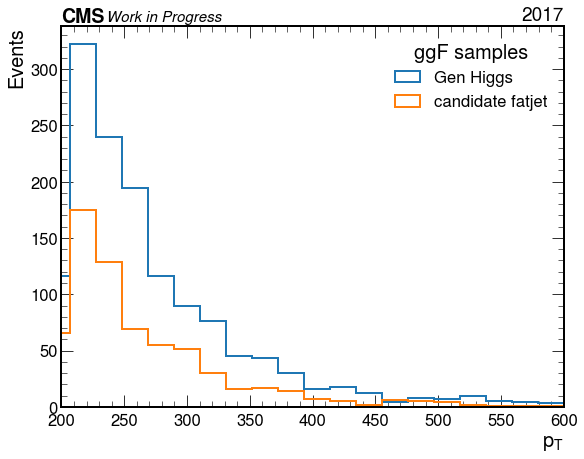

In [311]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(9, 7))

higgs_pt = ak.flatten(higgs).pt
higgs_pt = higgs_pt[higgs_pt>200]

fj_pt = ak.flatten(candidatefj, axis=0).pt
fj_pt = fj_pt[fj_pt>200]

ax.hist(higgs_pt, label=r"Gen Higgs", histtype="step", linewidth=2, bins=np.linspace(0,600,30))
ax.hist(fj_pt, label="candidate fatjet", histtype="step", linewidth=2, bins=np.linspace(0,600,30))

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.set_xlim(200, 600)
ax.legend(title=f"ggF samples")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"$p_T$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# ax.set_yscale("log")

# plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt.pdf", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


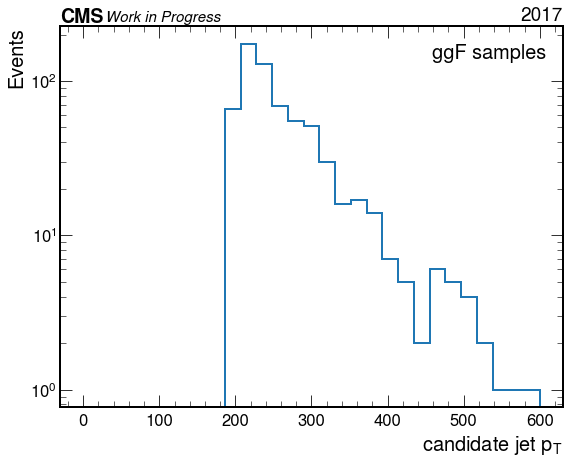

In [296]:

plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
ax.hist(ak.flatten(candidatefj, axis=0).pt, histtype="step", linewidth=2, bins=np.linspace(0,600,30))

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"ggF samples")
ax.set_ylabel(r"Events"); 
ax.set_xlabel(r"candidate jet $p_T$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_yscale("log")

# plt.savefig(f"/Users/fmokhtar/Desktop/hww/gen_higgs_pt.pdf", bbox_inches='tight')

In [254]:
print(f"Number of events with a candidatelep: {len(ak.flatten(candidatelep, axis=0))}")
print(f"Number of events with a candidatelep of pt>200: {ak.sum(candidatelep.pt>200)}")
print("-----------------------")
print(f"Number of events with a jet: {len(ak.flatten(events.Jet, axis=1))}")
print(f"Number of events with a good jet: {len(ak.flatten(goodjets, axis=1))}")
print("-----------------------")
print(f"Number of events with a fatjet: {len(ak.flatten(fatjets, axis=1))}")
print(f"Number of events with a good fatjet: {len(ak.flatten(good_fatjets, axis=1))}")
print(f"Number of events with a candidatefj: {len(ak.flatten(candidatefj, axis=0))}")
print(f"Number of events with a candidatefj of pt>200: {ak.sum(candidatefj.pt>200)}")

Number of events with a candidatelep: 16981
Number of events with a candidatelep of pt>200: 51
-----------------------
Number of events with a jet: 526289
Number of events with a good jet: 134498
-----------------------
Number of events with a fatjet: 3497
Number of events with a good fatjet: 2130
Number of events with a candidatefj: 660
Number of events with a candidatefj of pt>200: 660


In [257]:
ak.flatten(candidatefj, axis=0).pt

<Array [210, 234, 203, 350, ... 309, 220, 354] type='660 * float32[parameters={"...'>

In [258]:
ak.flatten(candidatelep, axis=0).pt

<Array [31.9, 37.5, 43.3, ... 44.8, 53.8, 34.3] type='16981 * float32'>

In [261]:
candidatelep

<Array [None, None, Muon, ... None, None, None] type='98400 * ?union[muon, elect...'>

In [267]:
np.where(candidatefj.pt)

(<Array [0, 1, 2, 3, ... 98397, 98398, 98399] type='98074 * int64'>,)

In [269]:
candidatefj.pt

<Array [None, None, None, ... None, None, None] type='98400 * ?float32[parameter...'>

In [10]:
candidatelep

<FatJetArray [None, None, None, ... None, None, None] type='98400 * ?fatJet'>

In [93]:
# events with a candidate jet
np.where(~ak.is_none(candidatefj))

(<Array [53, 99, 308, ... 98169, 98199, 98354] type='660 * int64'>,)

In [312]:
# check the candidate lepton in one of those events
candidatelep[53].genPartIdxG

1893

In [329]:
events.FatJet[53]

<FatJetArray [FatJet, FatJet] type='2 * fatJet'>

In [328]:
1893 in events.FatJet[53][0]["pFCandsIdxG"]

False

In [330]:
1893 in events.FatJet[53][1]["pFCandsIdxG"]

False

In [338]:
events.FatJet[53].electronIdx3SJ

<Array [-1, 0] type='2 * int32[parameters={"__doc__": "index of electron matched...'>

In [107]:
candidatelep.jetIdx[53]

3

In [113]:
events.Jet[53]

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='8 * jet'>

In [ ]:
candidatelep.jetIdx[53]

In [115]:
events.Jet[53].delta_r(candidatelep[53])

<Array [3.2, 0.657, 1.38, ... 2.64, 2.89, 1.94] type='8 * float32'>

In [103]:
candidatefj.tightleptonJetID

AttributeError: no field named 'tightleptonJetID'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.2/src/awkward/highlevel.py#L1124)

In [151]:
events.FatJet.fields

['area',
 'btagCSVV2',
 'btagDDBvLV2',
 'btagDDCvBV2',
 'btagDDCvLV2',
 'btagDeepB',
 'btagHbb',
 'deepTagMD_H4qvsQCD',
 'deepTagMD_HbbvsQCD',
 'deepTagMD_TvsQCD',
 'deepTagMD_WvsQCD',
 'deepTagMD_ZHbbvsQCD',
 'deepTagMD_ZHccvsQCD',
 'deepTagMD_ZbbvsQCD',
 'deepTagMD_ZvsQCD',
 'deepTagMD_bbvsLight',
 'deepTagMD_ccvsLight',
 'deepTag_H',
 'deepTag_QCD',
 'deepTag_QCDothers',
 'deepTag_TvsQCD',
 'deepTag_WvsQCD',
 'deepTag_ZvsQCD',
 'eta',
 'mass',
 'msoftdrop',
 'n2b1',
 'n3b1',
 'particleNetMD_QCD',
 'particleNetMD_Xbb',
 'particleNetMD_Xcc',
 'particleNetMD_Xqq',
 'particleNet_H4qvsQCD',
 'particleNet_HbbvsQCD',
 'particleNet_HccvsQCD',
 'particleNet_QCD',
 'particleNet_TvsQCD',
 'particleNet_WvsQCD',
 'particleNet_ZvsQCD',
 'particleNet_mass',
 'phi',
 'pt',
 'rawFactor',
 'tau1',
 'tau2',
 'tau3',
 'tau4',
 'lsf3',
 'jetId',
 'subJetIdx1',
 'subJetIdx2',
 'electronIdx3SJ',
 'muonIdx3SJ',
 'nConstituents',
 'DDX_tau1_flightDistance2dSig',
 'DDX_tau1_trackEtaRel_0',
 'DDX_tau1_trackEt

In [152]:
events.FatJet.subJetIdxG.__doc__

'index of first subjet'

In [127]:
candidatelep.fields

['dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'sip3d',
 'mvaTTH',
 'charge',
 'jetIdx',
 'pdgId',
 'tightCharge',
 'isPFcand',
 'jetNDauCharged',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'genPartIdxG',
 'jetIdxG']

In [37]:
fatjets.particleNetMD_Xbb

<Array [[], [], [], [], ... [], [], [], []] type='98400 * var * float32[paramete...'>

In [26]:
candidatefj[~ak.is_none(candidatefj)].pt

<Array [210, 234, 203, 350, ... 309, 220, 354] type='660 * ?float32[parameters={...'>

In [147]:
events.Muon.dz

<Array [[], [], [0.00812, ... [0.00706], []] type='98400 * var * float32[paramet...'>

In [12]:
dr_jet_lepfj = goodjets.delta_r(candidatefj)

In [13]:
btagWPs = {
    "deepJet": {
        "2016APV": {
            "L": 0.0508,
            "M": 0.2598,
            "T": 0.6502,
        },
        "2016": {
            "L": 0.0480,
            "M": 0.2489,
            "T": 0.6377,
        },
        "2017": {
            "L": 0.0532,
            "M": 0.3040,
            "T": 0.7476,
        },
        "2018": {
            "L": 0.0490,
            "M": 0.2783,
            "T": 0.7100,
        },
    }
}

In [31]:
a = pd.read_parquet("../outfiles/0-1_ele.parquet")

In [34]:
a["n_bjets_ophem_M"]

0      0
1      0
2      0
3      0
4      0
      ..
658    1
659    0
660    0
661    0
662    0
Name: n_bjets_ophem_M, Length: 663, dtype: int64

In [ ]:
n_bjets = ak.sum(goodjets[dr_jet_lepfj > 0.8].btagDeepFlavB>0.3, axis=1)

In [320]:
candidatefj.pt

<Array [None, None, None, ... None, None, None] type='98400 * ?float32[parameter...'>

In [260]:
good_fatjets.delta_phi(met)

<Array [None, None, [], ... None, None, None] type='98400 * option[var * float32]'>

In [374]:
x = candidatefj.mass[~ak.is_none(candidatefj.mass)]
y = (candidatefj-candidatelep_p4).mass[~ak.is_none((candidatefj-candidatelep_p4).mass)]

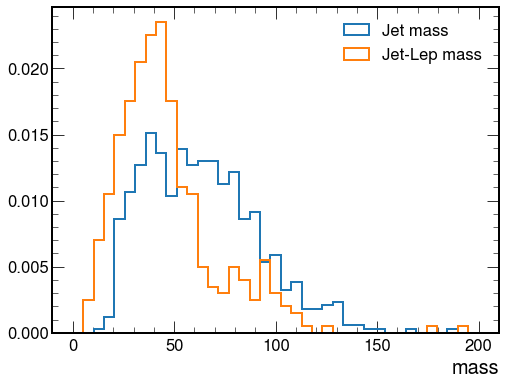

In [376]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 200, 40)

for sample in ["HWW"]:
    ax.hist(x, bins, histtype="step", linewidth=2, label = f"Jet mass", density=True)
    ax.hist(y, bins, histtype="step", linewidth=2, label = f"Jet-Lep mass", density=True)
    ax.legend()
    # ax.set_ylim(0, 20000)
    ax.set_xlabel(r"mass")
#     ax.set_yscale("log")

In [433]:
"""
Using the reference https://cds.cern.ch/record/1630709/files/MSc_thesis_Stefan_Richter_with_info_pages.pdf.
Also using:
    px = pt cos(phi)
    py = pt sin(phi)
    pz = pt sinh(eta)
"""

Lep = candidatelep_p4
Jet = candidatefj - Lep

### definitions
m_H = 125

m_Jet = Jet.mass
E_Jet = Jet.energy

m_Lep = Lep.mass
E_Lep = Lep.energy

# momentum vectors for Jet and Lep
px_Jet = Jet.pt * np.cos(Jet.phi)
py_Jet = Jet.pt * np.sin(Jet.phi)
pz_Jet = Jet.pt * np.sinh(Jet.eta)

px_Lep = Lep.pt * np.cos(Lep.phi)
py_Lep = Lep.pt * np.sin(Lep.phi)
pz_Lep = Lep.pt * np.sinh(Lep.eta)

pJet_dot_pLep = px_Jet*px_Lep + py_Jet*py_Lep + pz_Jet*pz_Lep

# met
px_met = met.pt * np.cos(met.phi)
py_met = met.pt * np.sin(met.phi)

# computation:
Last_term = (px_met*(px_Jet+px_Lep) + py_met*(py_Jet+py_Lep))
A = (1/(E_Jet+E_Lep)) * ( 0.5*(m_H**2 - m_Jet**2 - m_Lep**2) - E_Jet*E_Lep + pJet_dot_pLep + Last_term )

B = (pz_Jet**2 + pz_Lep**2) / (E_Jet + E_Lep)

D = A**2 - (px_met**2 + py_met**2)*(1-B**2)

# reconstruct the met pz
pz_met_pos = ( (A*B) + np.sqrt(D) ) / (1-B**2)
pz_met_neg = ( (A*B) - np.sqrt(D) ) / (1-B**2)

In [421]:
pz_met_pos = pz_met_pos[~ak.is_none(pz_met_pos)]
pz_met_neg = pz_met_neg[~ak.is_none(pz_met_neg)]

Text(1, 0, 'MET $p_z$')

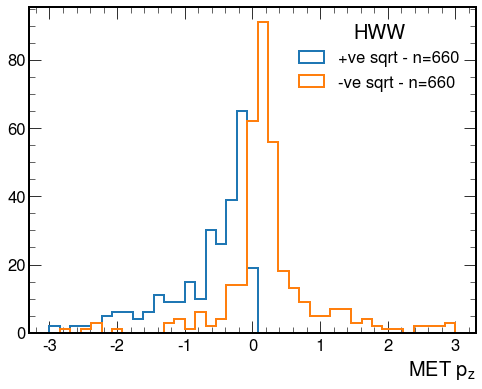

In [395]:
import math
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-3, 3, 40)
ax.hist(pz_met_pos, bins, histtype="step", linewidth=2, label = f"+ve sqrt - n={len(pz_met_pos)}")
ax.hist(pz_met_neg, bins, histtype="step", linewidth=2, label = f"-ve sqrt - n={len(pz_met_neg)}")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"MET $p_z$")

# Reconstruct the higgs

In [443]:
### pick smallest pz because we expect heavy physics to result in central object which has hight pT (artifact of pdf proton) - more probable to have less pT in z axis

met1 = ak.zip(
        {
            "pt": met.pt,
            "eta": np.arcsinh(pz_met/met.pt),
#             "eta": candidatelep_p4.eta,
            "phi": met.phi,
            "mass": 0,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )
# met2 = ak.zip(
#         {
#             "pt": met.pt,
# #             "eta": np.arcsinh(pz_met_neg/met.pt),
#             "eta": candidatelep_p4.eta,
#             "phi": met.phi,
#             "mass": 0,
# #             "charge": cand.charge,
#         },
#         with_name="PtEtaPhiMCandidate",
#         behavior=candidate.behavior,
#     )

ValueError: cannot broadcast records in this type of operation

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/_util.py#L1066)

In [444]:
rec_higgs1 = Jet+met1
rec_higgs1 = rec_higgs1[~ak.is_none(rec_higgs1)].mass

# rec_higgs2 = Jet+met2
# rec_higgs2 = rec_higgs2[~ak.is_none(rec_higgs2)].mass

Text(1, 0, 'rec Higgs mass')

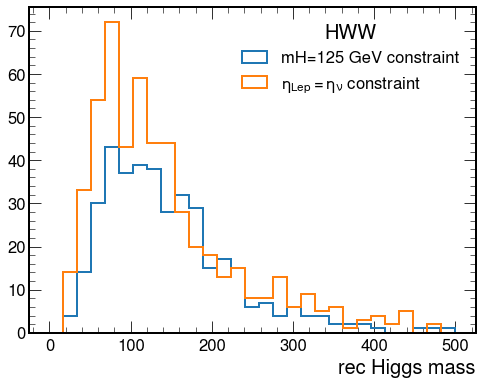

In [445]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 500, 30)

ax.hist(rec_higgs1, bins, histtype="step", linewidth=2, label = f"mH=125 GeV constraint")
ax.hist(rec_higgs2, bins, histtype="step", linewidth=2, label = r"$\eta_{Lep}=\eta_{\nu}$ constraint")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"rec Higgs mass")

In [280]:
rec_higgs[~ak.is_none(rec_higgs)].mass

<Array [305, 536, 281, ... 320, 837, 1.02e+03] type='547 * ?float64'>

In [ ]:
# ->goal is to see sharp peak near 125

### 1. share the mT histogram (<100 and >100)

### 2. why blue is not sharp peak
### 3. orange is reasonable
### 4. use eta_neut=eta_jet